# ConvLstm examples on Opportunity Dataset -` 2-modality data` 


In [66]:
import numpy as np
import scipy.io # load the matrix file
import pickle as cp
 
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.callbacks import TensorBoard 
from keras import metrics

from sklearn.model_selection import train_test_split
# example: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


# 1. Prepare the dataset `OPPORTUNITY Activity Recognition Data Set ` 

## 1. Wearable Sensor Data

In [67]:

def load_dataset(filename):
    """
    Function to load dataset 
    
    Argument:
        filename : the path of the preprocessed dataset
    
    Return:
    
        X_train
        y_train
        X_test
        y_test
        
    Notice:
        Need use `pickle(python3)` or`cpicckle(python2)` module to load and read dataset.
        
    
    """

    f = open(filename, 'rb')
    data = cp.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: X_train {0}, X_test {1}".format(X_train.shape, X_test.shape))
    print(" ..reading instances: y_train {0}, y_test {1}".format(y_train.shape, y_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('C:/Users/41762/Dropbox/Dataset/Opportunity/wearable_113_ambient_40_gestures_new.data')
print("Successfully")


Loading data...
 ..from file C:/Users/41762/Dropbox/Dataset/Opportunity/wearable_113_ambient_40_gestures_new.data
 ..reading instances: X_train (557963, 153), X_test (118750, 153)
 ..reading instances: y_train (557963,), y_test (118750,)
Successfully


In [68]:
y_train.max()
print("17 activities and 1 NaN classes")

17 activities and 1 NaN classes


In [69]:
# Opportunity num_classes = 18
num_classes = 18

In [70]:
y_train0 = to_categorical(y_train,num_classes=num_classes)
y_test0 = to_categorical(y_test,num_classes)

In [71]:
print(X_train0.shape)
print(y_train0.shape)

(23248, 24, 153)
(557963, 18)


# 2.Now, we have `X_train, A_train, X_test, A_test, y_train, y_test`

## 很显然我们需要用`sliding_window `来处理 `X_train` 和 `y_train` ，`A_train`&`A_test` to get the features
    1.参考Kronecker Product fusion method 来实验
        - 实验只用raw feature
        - 对比混合了attribute 的方法
    2. define `sliding_window`
    3. using sliding_window to process raw data into (rows,window_size,dimensions)


In [72]:
import numpy as np

'''
For time-series data only
win_len: how many samples do you want 
sliding_step: how many overlap do you want?

'''



def sliding_window(data,win_len,sliding_step,flatten=None):
    if len( data.shape )==1:
        # data = np.reshape(data,(data.shape[0],1))
        n_samples =  data.shape[0]
        dim=1
        n_windows = n_samples//sliding_step
        shape = (n_windows,win_len,)
        strides = data.itemsize*np.array([sliding_step*dim,dim,])
        result = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
        # result = np.expand_dims(result,axis=2)
        # result = np.reshape(result,(n_windows,sliding_step,1))
        print("Shape : {0} ---> {1} ".format(data.shape,result.shape))
        return result
    if len(data.shape)!=1:
        n_samples,dim = data.shape
        n_windows = n_samples // sliding_step
        shape = (n_windows,win_len,dim)
        strides = data.itemsize * np.array([sliding_step * dim,dim,1])
        result = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
        print("Shape : {0} ---> {1} ".format(data.shape, result.shape))
        return result


In [73]:

SLIDING_WINDOW_LENGTH = 24
SLIDING_WINDOW_STEP = 24

X_train0= sliding_window(X_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
y_train0 = sliding_window(y_train0,SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test0= sliding_window(X_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
y_test0 = sliding_window(y_test0, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)



Shape : (557963, 153) ---> (23248, 24, 153) 
Shape : (557963, 18) ---> (23248, 24, 18) 
Shape : (118750, 153) ---> (4947, 24, 153) 
Shape : (118750, 18) ---> (4947, 24, 18) 


In [74]:
y_test0.shape
y_train0.shape
# X_train0 = X_train0[:,:,0:113]
# X_test0 = X_test0[:,:,0:113]

F_train = X_train0[:,:,:113]
F_test = X_test0[:,:,:113]
X_train0.shape
F_test.shape


(4947, 24, 113)

# 2. Define the `ConvLstm` Model(113 fetures)

In [75]:
def model_variant(model, num_feat_map, dim, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':
        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,num_feat_map*dim)))
        model.add(LSTM(128, return_sequences=True, stateful=False))
        model.add(Dropout(0.2))
    if network_type == 'CNN':
         
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))

def model_conv(model, num_feat_map):
    model.add(Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_feat_map, 
                     kernel_size=(1, 5), 
                     activation='relu',
                     padding='same'))
    
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Dropout(0.2))
     

def model_LSTM(model):
    model.add(LSTM(num_hidden_lstm, 
               input_shape=(win_len,dim), 
               return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(num_hidden_lstm, return_sequences=False))
    model.add(Dropout(0.2))

# def model_LSTM(model):
    

# ### def model_MLP(model, num_hidden_mlp):
#     model.add(Dense(num_hidden_mlp, activation='relu', input_shape=(dim*win_len,)))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_hidden_mlp, activation='relu'))
#     model.add(Dropout(0.5))

def model_output(model):
    model.add(Dense(num_classes, activation='softmax'))

In [76]:
batch_size = 128
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 128



In [77]:
network_type = 'ConvLSTM'

In [78]:

_, win_len, dim = F_train.shape


In [79]:
F_train.shape

(23248, 24, 113)

In [80]:
def _data_reshaping(X_tr, X_va, network_type):
    _, win_len, dim = X_tr.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
         
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_tr = np.swapaxes(X_tr,1,2)
        X_va = np.swapaxes(X_va,1,2)
 
        X_tr = np.reshape(X_tr, (-1, dim, win_len, 1))
        X_va = np.reshape(X_va, (-1, dim, win_len, 1))
         
    if network_type=='MLP':
        print('MLP...')
        X_tr = np.reshape(X_tr, (-1, dim*win_len))
        X_va = np.reshape(X_va, (-1, dim*win_len))
     
    return X_tr, X_va

In [81]:
F_train, F_test = _data_reshaping(F_train, F_test, network_type)
print('F_test shape = ' + str(X_test.shape))

ConvLSTM
F_test shape = (118750, 153)


In [82]:
print(F_train.shape)

(23248, 113, 24, 1)


In [83]:
model = Sequential()

In [84]:
if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    

ConvLSTM


In [85]:
print(X_train0.shape)
model_output(model)    
model.summary()

(23248, 24, 153)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 113, 24, 16)       96        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 113, 24, 16)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 113, 24, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 113, 24, 16)       1296      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 24, 16)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 113, 24, 16)       0         
_________________________________________________________________
permute_2 (Permute)          (None, 24, 113, 16)       0   

# 3. Compile the model
- Chose `F1-Score` and `Cross-entropy Loss` and `Confusion Matrix` as the metrics

In [86]:
import keras.metrics
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# tensorboardCallBack = TensorBoard(log_dir='./Opportunity-Graph', histogram_freq=0, write_graph=True, write_images=True)

print(F_test.shape)
print(y_test0.shape)
print(F_train.shape)
print(y_train0.shape)

(4947, 113, 24, 1)
(4947, 24, 18)
(23248, 113, 24, 1)
(23248, 24, 18)


### 113 features outputs
- 0.63

In [87]:
y_test.shape

(118750,)

In [89]:
import sklearn.metrics as metrics
num_epochs =1
for _ in range(66):
    H = model.fit(F_train, y_train0,
                batch_size=batch_size,
                epochs=num_epochs,
                verbose=1,
                shuffle=True,
                validation_data=(F_test, y_test0)
    #             callbacks=[tensorboardCallBack]
                 )
    foo = model.predict_classes(F_test)
     
    foo_new = np.reshape(foo,(-1, ))
    print("\tTest f1 score(macro):\t{:.4f} ".format(metrics.f1_score(y_true=y_test[:foo_new.shape[0],], y_pred=foo_new,average="macro")))
    

Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 548us/step - loss: 0.0634 - acc: 0.9772 - val_loss: 0.4778 - val_acc: 0.9051
	Test f1 score(macro):	0.6002 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 551us/step - loss: 0.0716 - acc: 0.9747 - val_loss: 0.4765 - val_acc: 0.8982
	Test f1 score(macro):	0.6121 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 550us/step - loss: 0.0564 - acc: 0.9797 - val_loss: 0.4779 - val_acc: 0.9024
	Test f1 score(macro):	0.6159 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 549us/step - loss: 0.0543 - acc: 0.9806 - val_loss: 0.5026 - val_acc: 0.9023
	Test f1 score(macro):	0.5969 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 552us/step - loss:

23248/23248 [==============================] - 13s 552us/step - loss: 0.0479 - acc: 0.9835 - val_loss: 0.5593 - val_acc: 0.8969
	Test f1 score(macro):	0.5798 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 556us/step - loss: 0.0476 - acc: 0.9831 - val_loss: 0.5366 - val_acc: 0.8984
	Test f1 score(macro):	0.5905 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 547us/step - loss: 0.0757 - acc: 0.9740 - val_loss: 0.5048 - val_acc: 0.9037
	Test f1 score(macro):	0.6083 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
23248/23248 [==============================] - 13s 549us/step - loss: 0.0432 - acc: 0.9845 - val_loss: 0.5354 - val_acc: 0.9029
	Test f1 score(macro):	0.6235 
Train on 23248 samples, validate on 4947 samples
Epoch 1/1
 6784/23248 [=======>......................] - ETA: 8s - loss: 0.0354 - acc: 0.9873

KeyboardInterrupt: 

In [65]:
y_test0.shape

(4947, 24, 18)

In [56]:
foo = model.predict_classes(F_test)
foo.shape

(4947, 24)

In [60]:
new_foo = np.reshape(foo,(-1,))

In [61]:
new_foo.shape

(118728,)

In [36]:
24*4947

118728

### 37 features outputs
- 0.56
- 0.559
- 0.5688

In [97]:
import sklearn.metrics as metrics
num_epochs =1
for _ in range(66):
    H = model.fit(X_train, y_train1,
                batch_size=batch_size,
                epochs=num_epochs,
                verbose=1,
                shuffle=True,
                validation_data=(X_test, y_test1)
    #             callbacks=[tensorboardCallBack]
                 )
    foo = model.predict_classes(X_test)
    print("\tTest f1 score(macro):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="macro")))
    

Train on 46495 samples, validate on 9894 samples
Epoch 1/1
46495/46495 [==============================] - 7s 145us/step - loss: 0.7331 - acc: 0.8061 - val_loss: 0.5483 - val_acc: 0.8942
	Test f1 score(macro):	0.5847 
Train on 46495 samples, validate on 9894 samples
Epoch 1/1
 1024/46495 [..............................] - ETA: 5s - loss: 0.7373 - acc: 0.8066

C:\Users\41762\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


46495/46495 [==============================] - 7s 143us/step - loss: 0.7303 - acc: 0.8065 - val_loss: 0.5483 - val_acc: 0.8917
	Test f1 score(macro):	0.5668 
Train on 46495 samples, validate on 9894 samples
Epoch 1/1
46495/46495 [==============================] - 7s 144us/step - loss: 0.7349 - acc: 0.8065 - val_loss: 0.5320 - val_acc: 0.8911
	Test f1 score(macro):	0.5689 
Train on 46495 samples, validate on 9894 samples
Epoch 1/1
46495/46495 [==============================] - 7s 147us/step - loss: 0.7293 - acc: 0.8068 - val_loss: 0.5587 - val_acc: 0.8892
	Test f1 score(macro):	0.5507 
Train on 46495 samples, validate on 9894 samples
Epoch 1/1
46495/46495 [==============================] - 7s 151us/step - loss: 0.7323 - acc: 0.8057 - val_loss: 0.5393 - val_acc: 0.8907
	Test f1 score(macro):	0.5628 
Train on 46495 samples, validate on 9894 samples
Epoch 1/1
46495/46495 [==============================] - 7s 147us/step - loss: 0.7393 - acc: 0.8043 - val_loss: 0.5286 - val_acc: 0.8929
	Test

KeyboardInterrupt: 

In [24]:
#model = keras.models.load_model("ConvLSTM-Opportunity-Model.h5")

# 2. Define the `ConvLstm` Model(37 fetures)

In [49]:
# batch_size = 128
# num_feat_map = 16
# num_hidden_mlp = 128
# num_hidden_lstm = 32

# _, win_len, dim = X_train.shape
# network_type = 'ConvLSTM'

ValueError: too many values to unpack (expected 3)

In [50]:
model2 = Sequential()

if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model, num_feat_map)
    model_variant(model, num_feat_map, dim, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP': 
    model_MLP(model, num_hidden_mlp) 
    
print(X_train0.shape)
model_output(model)    
model.summary()
    

ValueError: Input 0 is incompatible with layer conv2d_3: expected ndim=4, found ndim=2

# 4. Save the model into file

In [25]:
from keras.models import load_model

# model.save("ConvLSTM-Opportunity-Model.h5")
# model = keras.models.load_model("ConvLSTM-Opportunity-Model.h5")

In [26]:
X_test.shape

(9894, 113, 24, 1)

In [27]:
y_test0.shape


(9894,)

In [28]:
X_test.shape

(9894, 113, 24, 1)

In [29]:
foo = model.predict_classes(X_test)

# 5. `f1-score` and `confusion matrix`
macro
- 0.63
- 0.617

In [95]:
# Results presentation
import time
start_time = time.time()

print("||Results||")


import sklearn.metrics as metrics


print("\tTest f1 score(macro):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="macro")))
print("\tTest f1 score(weighted):\t{:.4f} ".format(metrics.f1_score(y_true=y_test0, y_pred=foo,average="weighted")))

# print("\tTest confusion matrix:\t{:} ".format(metrics.confusion_matrix(y_test0, y_pred=foo)))
# print("\tTest fscore:\t{:} ".format(metrics.(y_test0, y_pred=foo)))

print("\tTook {:.3f}s.".format( time.time() - start_time))


||Results||
	Test f1 score(macro):	0.5734 
	Test f1 score(weighted):	0.8631 
	Took 0.005s.


C:\Users\41762\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 6. plot the confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

Confusion matrix, without normalization
[[8146    4    0    2    1   16   12    8   14    5    6    2    2    4
    15    0    0    0]
 [  27   27    0    4    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  53    0   41    0    1    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  27   10    0   23    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  31    0    0    0   52    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [  98    0    0    0    0  120   10    0    0    0    0    0    0    0
     0    0    0    0]
 [  27    0    0    0    0    5  128    0    0    0    0    0    0    0
     0    0    0    0]
 [  32    0    0    0    0    0    0   65    3    0    0    0    0    0
     0    0    0    0]
 [  15    0    0    0    0    0    0    3   59    0    0    0    0    0
     0    0    0    0]
 [  15    0    0    0    0    0    0    0    0   21    1    0    0    0
     2    0    0    0]
 [  17    

C:\Users\41762\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


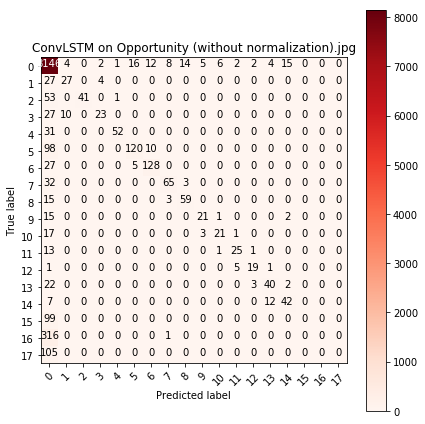

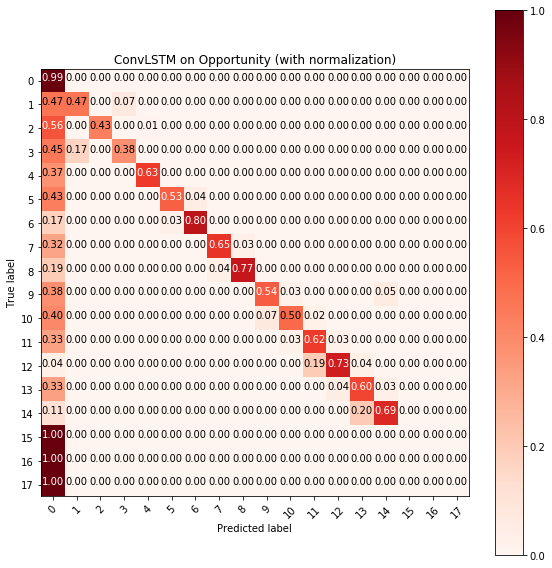

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test0, foo)
np.set_printoptions(precision=3)


# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix,classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
                      title='ConvLSTM on Opportunity (without normalization).jpg')
# plt.savefig("ConvLSTM on Opportunity (without normalization).jpg")

#Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], normalize=True,
#                        title='Normalized confusion matrix')
                      title='ConvLSTM on Opportunity (with normalization)')
plt.savefig("F1 Score({0}features)={1:.3f}.jpg".format(dim,metrics.f1_score(y_true=y_test0, y_pred=foo,average="macro")))
plt.show()